# Topic dynamics (try 1)

In [1]:
import time
import bz2
import json
import pickle
import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN, Birch, AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = '/sciclone/data10/twford/reddit/reddit/comments/'
BASE_PATH = '/sciclone/geograd/stmorse/reddit/'

In [ ]:
"""
COMPUTE KEYWORDS by cluster by year
OUTPUT: corpi {cluster #: {corpus, keywords}}

COMPUTE CLUSTER MEMBERSHIP for topic
OUTPUT: membership {keyword: {year: {clusters, amount}}}

CHOOSE TOPIC CLUSTER SEQUENCES
compare membership against keywords
manually choose sequence for each topic
OUTPUT: {topic_word: [cluster seq], ...}

CONCAT AND DIM-REDUCE top comments and centroids
[
    [0-k] top comments for topic 0, cluster 2007
    [k-N] top comments for topic 0, cluster 2011
    ...
    []
]

VIZ
"""

### Compute `corpi` (top samples, keywords, by year)

In [8]:
# number of embeddings/sentences closest to centroid
# more allows a better tf-idf estimate of keywords
top_k = 100

years = [2007, 2008, 2009, 2010, 2011]
# years = [2007]

# just picking from one month to keep time down
month = '03'

# main output - will hold {year: {cluster: {corpus_sample, keywords}...}...}
corpi = {}

for year in years:
    print('Loading year ', year)

    # load cluster centers
    model_cc = utils.load_cc(f'mbkm_40_{year}_td2_cc', base_path=BASE_PATH+'td2/')
    num_clusters = model_cc.shape[0]

    # load embeddings
    print('Load embeddings...')
    embeddings = utils.load_npz(BASE_PATH, year, month, 'embeddings')

    # get index of closest to centroid
    closest_idx = np.zeros((num_clusters, top_k))
    for i in range(num_clusters):
        closest_idx[i,:] = utils.get_closest_vectors(
            model_cc[i], embeddings, top_k=top_k)

    # build corpus
    # this will hold sentences vic centroid (row=cluster, entry=concat'd sentences)
    print('Build corpus...')
    corpus = ['' for _ in range(num_clusters)]
    sentences = utils.load_sentences_bz2(DATA_PATH, year, month)
    for i in range(num_clusters):
        corpus[i] += ' --- '.join([sentences[int(j)] for j in closest_idx[i,:]])

    print('Computing tf-idf...')
    vectorizer = TfidfVectorizer(
        input='content',
        max_df=0.3,
        # max_features=100,  # this seems to get rid of weird/rare words
        use_idf=True,
        smooth_idf=True
    )

    X = vectorizer.fit_transform(corpus)
    
    keywords = []
    for i in range(num_clusters):
        max_idx = np.argsort(X[i,:].toarray().flatten())[::-1][:5]
        keyword = vectorizer.get_feature_names_out()[max_idx]
        keywords.append(keyword)

    corpi[year] = {
        i: {
            'corpus': corpus[i],
            'keywords': keywords[i]
        } for i in range(num_clusters)
    }

Loading year  2007
Load embeddings...
Build corpus...
Computing tf-idf...
Loading year  2008
Load embeddings...
Build corpus...
Computing tf-idf...
Loading year  2009
Load embeddings...
Build corpus...
Computing tf-idf...
Loading year  2010
Load embeddings...
Build corpus...
Computing tf-idf...
Loading year  2011
Load embeddings...
Build corpus...
Computing tf-idf...


In [9]:
with open('/sciclone/geograd/stmorse/reddit/td2/corpi.pkl', 'wb') as f:
    pickle.dump(corpi, f)

In [14]:
for year in years:
    print(year)
    for i, vals in corpi[year].items():
        print(f'{i}: ', vals['keywords'])

2007
0:  ['ron' 'paul' 'republican' 'candidate' 'gop']
1:  ['customers' 'companies' 'marketing' 'profits' 'stores']
2:  ['firefox' 'browser' 'linkjacked' 'mozilla' 'graphic']
3:  ['parents' 'child' 'abortion' 'sex' 'birth']
4:  ['lisp' 'language' 'haskell' 'python' 'languages']
5:  ['hilarious' 'funniest' 'amused' 'laughing' 'laughed']
6:  ['hello' 'hola' 'meh' 'hehe' 'nothng']
7:  ['movie' 'documentary' 'borat' 'videos' 'clip']
8:  ['himself' 'interview' 'vehicles' 'nut' 'ballmer']
9:  ['police' 'cops' 'crime' 'gun' 'legal']
10:  ['racism' 'racist' 'white' 'black' 'iq']
11:  ['religion' 'religious' 'atheist' 'christianity' 'atheism']
12:  ['freedom' 'libertarian' 'citizens' 'capitalism' 'capitalist']
13:  ['facts' 'bias' 'scientific' 'warming' 'scientists']
14:  ['11' 'media' 'conspiracy' 'fox' 'ap']
15:  ['apple' 'price' 'linux' 'os' 'hardware']
16:  ['jpg' 'image' 'photo' 'artist' 'images']
17:  ['warming' 'global' 'climate' 'carbon' 'gore']
18:  ['smoke' 'drink' 'cocaine' 'nitrous'

### Compute `topic_map` (cluster membership for topic words)

In [ ]:
# topic_words = ['war', 'film', 'ha!', 'obama']

# membership {keyword: {year: {clusters, amount}}}
# topic_map = {term: {} for term in topic_words}

# top_k = 3                   # num clusters with this word dominant to grab
# month = '03'                # for now just base the doc freq off one month

# for term in topic_words:
#     print(f'\nTERM: {term}\n-----')

#     for year in years:
#         print(f'Processing {year} ...')

#         # grab indices of this term in a given year
#         with bz2.BZ2File(f'{DATA_PATH}RC_{year}-{month}.bz2', 'rb') as f:
#             idx = []
#             k = 0
#             for line in f:
#                 entry = json.loads(line)
#                 if 'body' not in entry or entry['author'] == '[deleted]':
#                     continue
                
#                 # this is very rough -- quotes and many other things mess it up
#                 if term in entry['body'].lower():
#                     idx.append(k)

#                 k += 1

#         # this is indices in month to this term
#         idx = np.array(idx)

#         # grab labels for this term
#         labs = utils.load_npz(f'/sciclone/geograd/stmorse/reddit/td2/', 
#                             year, month, 'labels')

#         # grab labels and label count of sentences containing this term
#         cluster, count = np.unique(labs[idx], return_counts=True)
#         top_c_idx = np.argsort(count)[::-1][:top_k]
#         # print(f'All: {[(cl, co) for cl, co in zip(cluster, count)]}')
#         print(f'> Found {idx.shape}. Top: ', cluster[top_c_idx], count[top_c_idx])
        
#         # add to topic_map
#         topic_map[term][year] = {
#             'labels': cluster[top_c_idx],
#             'counts': count[top_c_idx]
#         }

In [17]:
# created manually
topic_words = ['obama', 'police', 'atheism', 'ha']

topic_map = {
    'obama': {
        2007: {'labels': [4]},
        2008: {'labels': [19]},
        2009: {'labels': [20]},
        2010: {'labels': [20]},
        2011: {'labels': [20]}
    },
    'police': {
        2007: {'labels': [9]},
        2008: {'labels': [36]},
        2009: {'labels': [13]},
        2010: {'labels': [13]},
        2011: {'labels': [13]}
    },
    'atheism': {
        2007: {'labels': [11]},
        2008: {'labels': [38]},
        2009: {'labels': [23]},
        2010: {'labels': [23]},
        2011: {'labels': [23]}
    },
    'ha': {
        2007: {'labels': [26]},
        2008: {'labels': [2]},
        2009: {'labels': [32]},
        2010: {'labels': [32]},
        2011: {'labels': [32]}
    }
}

In [ ]:
# with open('/sciclone/geograd/stmorse/reddit/td2/topic_map.pkl', 'wb') as f:
#     pickle.dump(topic_map, f)

### Compute `topic_sequences`

In [ ]:
# for term, tmap in topic_map.items():
#     print(f'TERM: {term}')

#     # peek at keywords corresponding to the high-count cluster
#     for year in years:
#         print(f'Year {year}')
#         for label in tmap[year]['labels']:
#             print(f'> {label}: ', corpi[year][label]['keywords'])

#     print('\n-----\n')

In [18]:
topic_sequences = {
    term: [topic_map[term][year]['labels'][0] for year in years] for term in topic_words
}
topic_sequences

{'obama': [4, 19, 20, 20, 20],
 'police': [9, 36, 13, 13, 13],
 'atheism': [11, 38, 23, 23, 23],
 'ha': [26, 2, 32, 32, 32]}

### Combine embeddings (sentences and centroids)

In [23]:
combo = {term: {
    'embeddings': np.zeros((200,384)), 
    'centroids': np.zeros((5,384))
    } for term in topic_words
}

top_k = 100

for yx, year in enumerate(years):
    print('Loading year ', year)

    # load cluster centers
    model_cc = utils.load_cc(f'mbkm_40_{year}_td2_cc', base_path=BASE_PATH+'td2/')
    num_clusters = model_cc.shape[0]

    # store corresponding centroids for each term
    for term in topic_words:
        label = topic_sequences[term][yx]
        combo[term]['centroids'][yx,:] = model_cc[label,:]

    if year==2007 or year==2011:
        row = 0 if year==2007 else 100

        # load embeddings
        print('Load embeddings...')
        embeddings = utils.load_npz(BASE_PATH, year, month, 'embeddings')

        # get index of closest to all centroids
        closest_idx = np.zeros((num_clusters, top_k))
        for i in range(num_clusters):
            closest_idx[i,:] = utils.get_closest_vectors(
                model_cc[i], embeddings, top_k=top_k)
            
        # store the closest embeddings in the right block of combo for each term
        for term in topic_words:
            cx = topic_sequences[term][yx]
            cidx_int = [int(ii) for ii in closest_idx[cx]]
            combo[term]['embeddings'][row:row+100,:] = embeddings[cidx_int,:]

Loading year  2007
Load embeddings...
Loading year  2008
Loading year  2009
Loading year  2010
Loading year  2011
Load embeddings...


In [24]:
with open('/sciclone/geograd/stmorse/reddit/td2/combo.pkl', 'wb') as f:
    pickle.dump(combo, f)

### Dimension reduce and visualize

In [28]:
bigmat = []
for term in topic_words:
    bigmat.append(combo[term]['embeddings'])

for term in topic_words:
    bigmat.append(combo[term]['centroids'])

bigmat = np.vstack(bigmat)
bigmat.shape

(820, 384)

In [ ]:
"""
0:100 - term 0 2007
100:200 - term 0 2011
...
:800
800:805 - term 0 centroids
"""

In [33]:
tsne = TSNE(
    n_components=2, 
    perplexity=12,
    early_exaggeration=12)

X = tsne.fit_transform(bigmat)

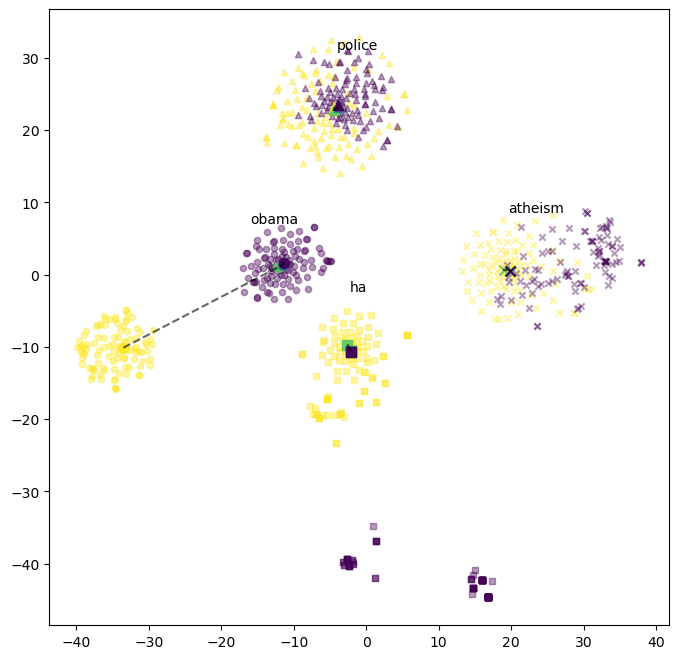

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

colors = plt.get_cmap('viridis_r')(np.linspace(0, 1, len(years)))
markers = ['o', '^', 'x', 's', 'P']

for i, term in enumerate(topic_words):
    # plot data points 2007
    bx = i*200
    ax.scatter(X[bx:bx+100, 0], X[bx:bx+100, 1], 
               s=20, color=colors[0], marker=markers[i], alpha=0.4)

    # plot data points 2011
    bx = i*200 + 100
    ax.scatter(X[bx:bx+100, 0], X[bx:bx+100, 1], 
               s=20, color=colors[4], marker=markers[i], alpha=0.4)
    
    bx = 800 + i*5

    # plot line connecting this terms centroids
    ax.plot(X[bx:bx+5, 0], X[bx:bx+5, 1], 'k--', alpha=0.6)

    # plot scatter of each centroid to do multi-color
    for k in range(5):
        ax.scatter(X[bx+k, 0], X[bx+k, 1], 
                   s=50, color=colors[k], marker=markers[i], alpha=0.9)
        
    cp = np.average(X[bx:bx+5], axis=0)
    ax.text(cp[0], cp[1]+8, term)

plt.show()


In [36]:
z = np.arange(16).reshape(4,4)
np.average(z, axis=0)

array([6., 7., 8., 9.])

# Linear regression experiments

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

(100, 2)
(30, 1) (30, 2)


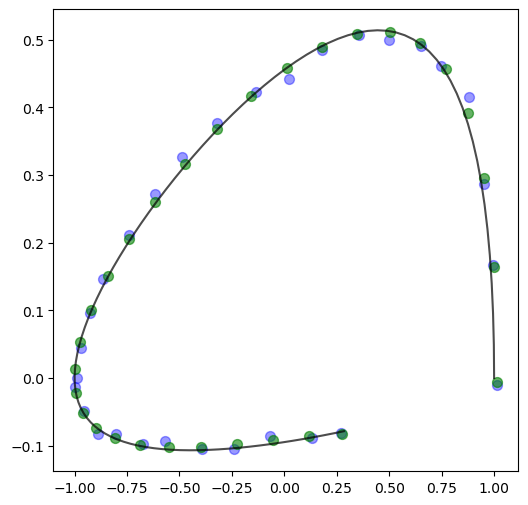

In [14]:
fun = lambda t: (np.cos(t), np.exp(-0.5*t)*np.sin(t))
fun = np.vectorize(fun)

ts = np.linspace(0, 5, 100)
ys_true = np.array(fun(ts)).T

print(ys_true.shape)

N = 30
ts_data = np.linspace(0, 5, N)
ys_data = np.array(fun(ts_data)).T + np.random.normal(0, 0.01, size=(N,2))
ts_data = ts_data.reshape((N, 1))
print(ts_data.shape, ys_data.shape)

degree = 5
models = [make_pipeline(PolynomialFeatures(degree), LinearRegression()) for _ in range(2)]

ys_pred = np.zeros((N, 2))
for i in range(2):
    models[i].fit(ts_data, ys_data[:,i])
    ys_pred[:,i] = models[i].predict(ts_data)

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(ys_true[:,0], ys_true[:,1], 'k-', alpha=0.7)
ax.scatter(ys_data[:,0], ys_data[:,1], s=50, color='b', alpha=0.4)
ax.scatter(ys_pred[:,0], ys_pred[:,1], s=50, color='g', alpha=0.6)

plt.show()